# A walk through the SPARCSpy Ecosystem

This notebook will introduce you to the SPARCSpy ecosystem and give you a complete working example of how to use SPARCSpy. It will walk you through the following steps of the SPARCSpy workflow:
1. **segmentation**: Generates masks for the segmentation of input images into individual cells
2. **extraction**: The segmentation masks are applied to extract single-cell images for all cells in the input images. Images of individual cells are rescaled to [0, 1] per channel.
3. **classification**: The image-based phenotype of each individual cell in the extracted single-cell dataset is classified using the specified classification method. Multiple classification runs can be performed on the same dataset using different classification methods. Here we utilize the pretrained binary classifier from the original [SPARCS manuscript](https://doi.org/10.1101/2023.06.01.542416) that identifies individual cells defective in a biological process called "autophagy". 
4. **selection**: Cutting instructions for the isolation of selected individual cells by laser microdissection are generated. The cutting shapes are written to an ``.xml`` file which can be loaded on a leica LMD microscope for automated cell excision.

The data used in this notebook was previously stitched using the stitching workflow in [SPARCStools](https://github.com/MannLabs/SPARCStools). Please see the notebook [here](https://mannlabs.github.io/SPARCStools/html/pages/notebooks/example_stitching_notebook.html).

## Import Required Libraries

First we need to import all of the python functions we require to run the pipeline.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

from sparcscore.pipeline.project import Project
from sparcscore.pipeline.workflows import WGASegmentation
from sparcscore.pipeline.extraction import HDF5CellExtraction
from sparcscore.pipeline.classification import MLClusterClassifier
from sparcscore.pipeline.selection import LMDSelection

## Generate the Project Structure

Executing this code will generate a new SPARCSpy project in the designated location. Each SPARCSpy project has the following general structure:

                .
                ├── classification
                │   └── classifier_name
                │       └── processing.log
                ├── config.yml
                ├── extraction
                ├── segmentation
                └── processing.log

In [2]:
project_location = f"../../../example_data/example_1/project"

project = Project(os.path.abspath(project_location),
                  config_path= "../../../example_data/example_1/config_example1.yml",
                  overwrite=True,
                  debug=True,
                  segmentation_f=WGASegmentation,
                  extraction_f=HDF5CellExtraction,
                  classification_f=MLClusterClassifier,
                  selection_f=LMDSelection
                  )

modifying config
[12/07/2024 15:00:44] Loading config from /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/config.yml
[12/07/2024 15:00:44] Loading classes from default classes path: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/classes.csv
[12/07/2024 15:00:44] Setup output folder at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/extraction/data
[12/07/2024 15:00:44] current run: 0


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/project.py:152: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


## Load Imaging Data

Once we have generated our project structure we next need to load our imaging data. There are several different ways to do this. 

1. you can load the images directly from file by specifying a list of filepaths
2. you can load the images from numpy arrays that are already loaded into memory

Here it is important that you load the channels in the following order: Nucleus, Cellmembrane, others

In this particular example we are utilizing images from U2OS cells which are stained with Hoechst 33342 to visualize nuclei and express Lck-mNeon to visualize the cellular membrane and LC3B-mcherry, a fluroescently tagged protein relevant for visualizing the biological process of autophagy. The cells have not been stimulated to induce autophagy and should be autophagy defective.

### Method 1: loading images from file

In [3]:
images = ["../../../example_data/example_1/input_images/Ch1.tif",
          "../../../example_data/example_1/input_images/Ch2.tif",
          "../../../example_data/example_1/input_images/Ch3.tif"]

project.load_input_from_file(images)

[12/07/2024 15:00:44] Overwrite is set to True. Existing input image was deleted.
[12/07/2024 15:00:45] saved input_image: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/input_image.ome.zarr


### Method 2: loading images from numpy array

To simulate the case where the images you want to load are already loaded as a numpy array, we first convert the images to a numpy array and then pass this array to the project instead of only providing the image paths.

In [4]:
from tifffile import imread

images = ["../../../example_data/example_1/input_images/Ch1.tif",
          "../../../example_data/example_1/input_images/Ch2.tif",
          "../../../example_data/example_1/input_images/Ch3.tif"]

image_arrays = np.array([imread(path) for path in images])

project.load_input_from_array(image_arrays)

[12/07/2024 15:00:45] Overwrite is set to True. Existing input image was deleted.
[12/07/2024 15:00:45] saved input_image: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/input_image.ome.zarr


### Looking at the loaded images

The loaded images are accesible via the input_image parameter of the project and are saved as numpy arrays with the following structure (c, x, y)

In [5]:
project.input_image

array([[[   0,    0,    0, ..., 2393, 2404,    0],
        [   0, 1494, 1253, ..., 2349, 2209,    0],
        [   0, 1343, 1449, ..., 2593, 2386,    0],
        ...,
        [   0, 4092, 4057, ...,  230,  217,    0],
        [   0, 4620, 4303, ...,  254,  219,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       [[   0,    0,    0, ...,  872,  659,    0],
        [   0,  310,  456, ...,  595,  273,    0],
        [   0,  471,  312, ...,  636,  441,    0],
        ...,
        [   0,  995,  903, ..., 1089, 1293,    0],
        [   0,  989,  853, ..., 1369, 1586,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       [[   0,    0,    0, ...,  783, 1122,    0],
        [   0,    1,    2, ...,  882,  959,    0],
        [   0,   44,   65, ...,  856,  806,    0],
        ...,
        [   0,  129,   92, ...,  634,  312,    0],
        [   0,  444,  232, ...,  469,  265,    0],
        [   0,    0,    0, ...,    0,    0,    0]]], dtype=uint16)

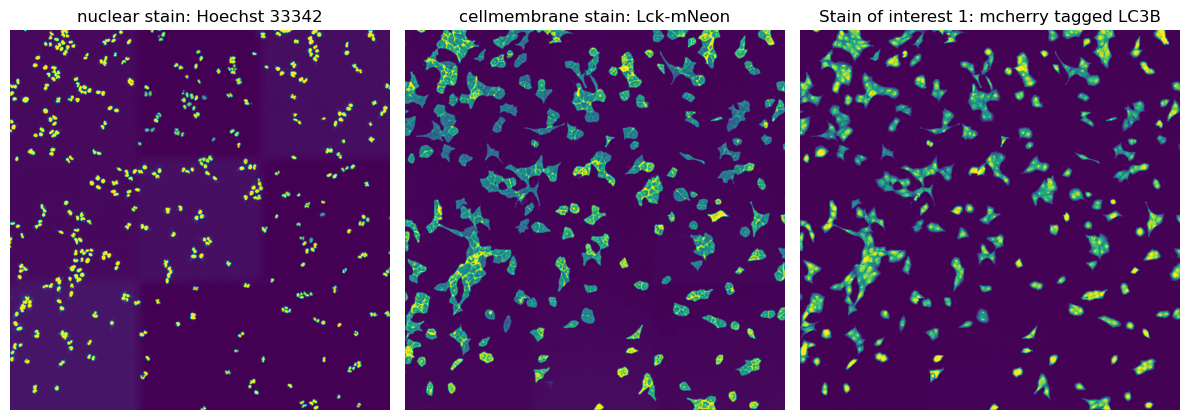

In [6]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

fig, axs = plt.subplots(1, 3, figsize = (12, 6));
axs[0].imshow(project.input_image[0]);
axs[0].axis("off");
axs[0].set_title("nuclear stain: Hoechst 33342")

axs[1].imshow(project.input_image[1]);
axs[1].axis("off");
axs[1].set_title("cellmembrane stain: Lck-mNeon")

axs[2].imshow(project.input_image[2]);
axs[2].axis("off");
axs[2].set_title("Stain of interest 1: mcherry tagged LC3B")

fig.tight_layout()

## Generating a Segmentation

SPARCSpy has different segmentation workflows between which you can choose. If none of them fit your needs you can also easily write your own. 

Here we will demonstrate the CPU based classical segmentation method that was also utilized in the manuscript. 

We define the segmentation method to be used when we initialize the project. In this case we used the `WGASegmentation` method. The `ShardedWGASegmentation` works very similarily but allows you to process several image chunks in parallel for more efficient computation on large input images.

By specifying `debug = True` we can see intermediate output results from the segmentation. 

The `WGASegmentation` method relies on parameters specified in the `config.yml` we loaded when initializing our project.

                WGASegmentation:
                    input_channels: 3
                    chunk_size: 50 # chunk size for chunked HDF5 storage
                    lower_quantile_normalization:   0.001
                    upper_quantile_normalization:   0.999
                    median_filter_size:   4 # Size in pixels
                    nucleus_segmentation:
                        lower_quantile_normalization:   0.01 
                        upper_quantile_normalization:   0.99 
                        median_block: 41 
                        median_step: 4
                        threshold: 0.2 
                        min_distance: 8 
                        peak_footprint: 7 
                        speckle_kernel: 9 
                        dilation: 0 # final dilation of pixel mask       
                        min_size: 200 # minimum nucleus area in pixel
                        max_size: 5000 # maximum nucleus area in pixel
                        contact_filter: 0.5 # minimum nucleus contact with background
                    wga_segmentation:
                        threshold: 0.05 
                        lower_quantile_normalization: 0.01
                        upper_quantile_normalization: 0.99
                        erosion: 2 
                        dilation: 7 
                        min_clip: 0
                        max_clip: 0.2
                        min_size: 200
                        max_size: 30000
                    chunk_size: 50

By passing the parameter ``debug = True`` we tell SPARCSpy to also generate intermediate outputs which we can look at to see the different segmentation steps. It is only recommended to do this for debugging or visualization purposes as it will utilize more memory and be slower.

For the ``WGASegmentation`` method the intermediate outputs that are displayed are the following: 

1. percentile normalized input images for each of the three channels (3 images)
2. median normalized input images (this slightl smooths the images for a better segmentation result) (3 images)
3. histogram showing the intensity distribution for nuclear and cytosolic channel (2 plots)
4. generated mask after applying nuclear thresholding
5. nuclear thresholding mask with calculated centers for each detected nucleus
6. fast marching map with nuclei centers indicated in red
7. segmented individual nuclei (2 different visualizations)
8. starting nucleus mask for filtering
9. histrogram showing size distribution of segmented nuclei
10. segmentation mask with too small nuclei shown in red
11. segmentation mask with too large nuclei shown in red
12. WGA thresholding mask
13. WGA potential map
14. WGA fast marching results
15. Watershed results with nuclear centers shown in red
15. WGA mask
16. Cytosol size distribution
10. cytosol mask with too small cells shown in red
11. cytosol mask with too large cells shown in red


[12/07/2024 15:00:46] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./WGASegmentation_raqzvqnq for WGASegmentation
[12/07/2024 15:00:46] No existing map 0 normalized found at path /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/0_normalized_map.npy, new one will be created
[12/07/2024 15:00:46] No existing map 1 median found at path /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/1_median_map.npy, new one will be created
[12/07/2024 15:00:46] No existing map 2 nucleus_segmentation found at path /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/2_nucleus_segmentation_map.npy, new one will be created
[12/07/2024 15:00:46] No existing map 3 nucleus_mask found at path /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/3_nucleus_mask_map.npy, new one will be created
[12/07/2024 15:00:46] No existi

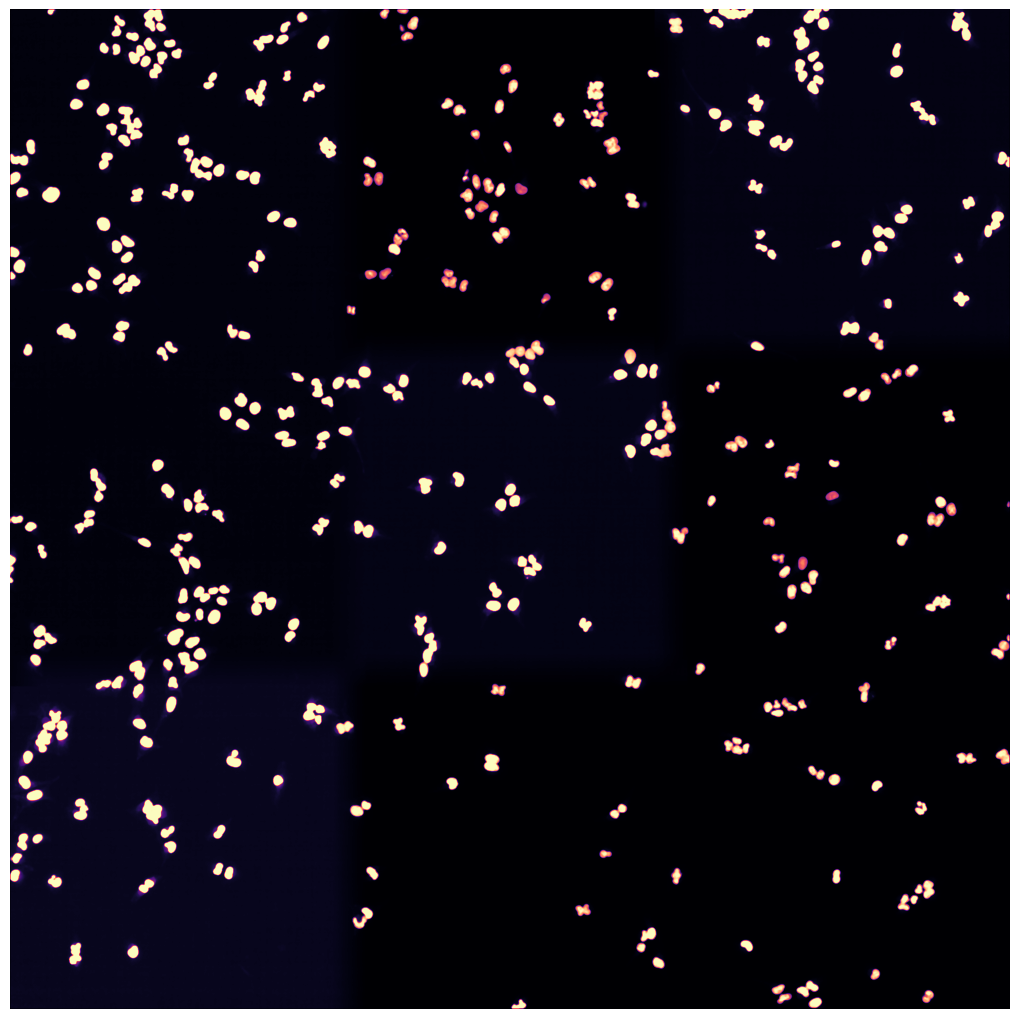

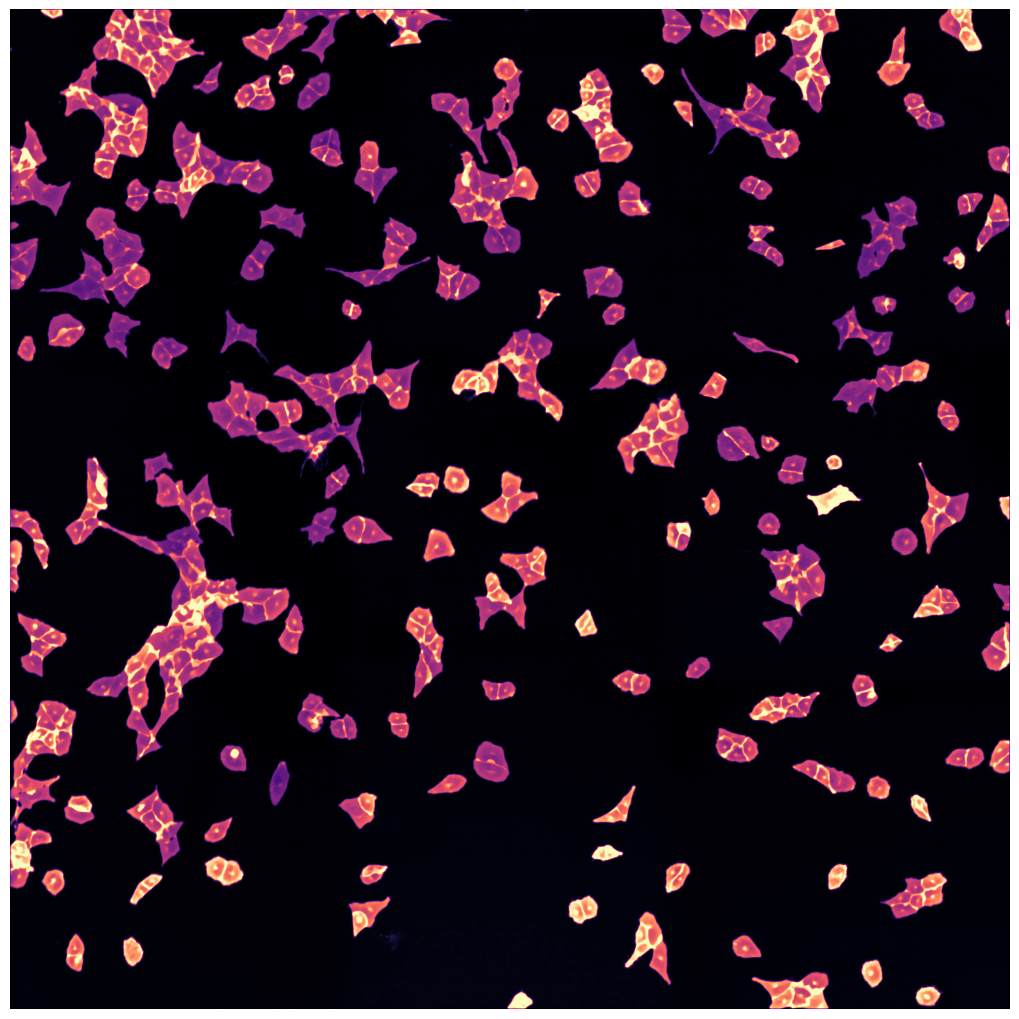

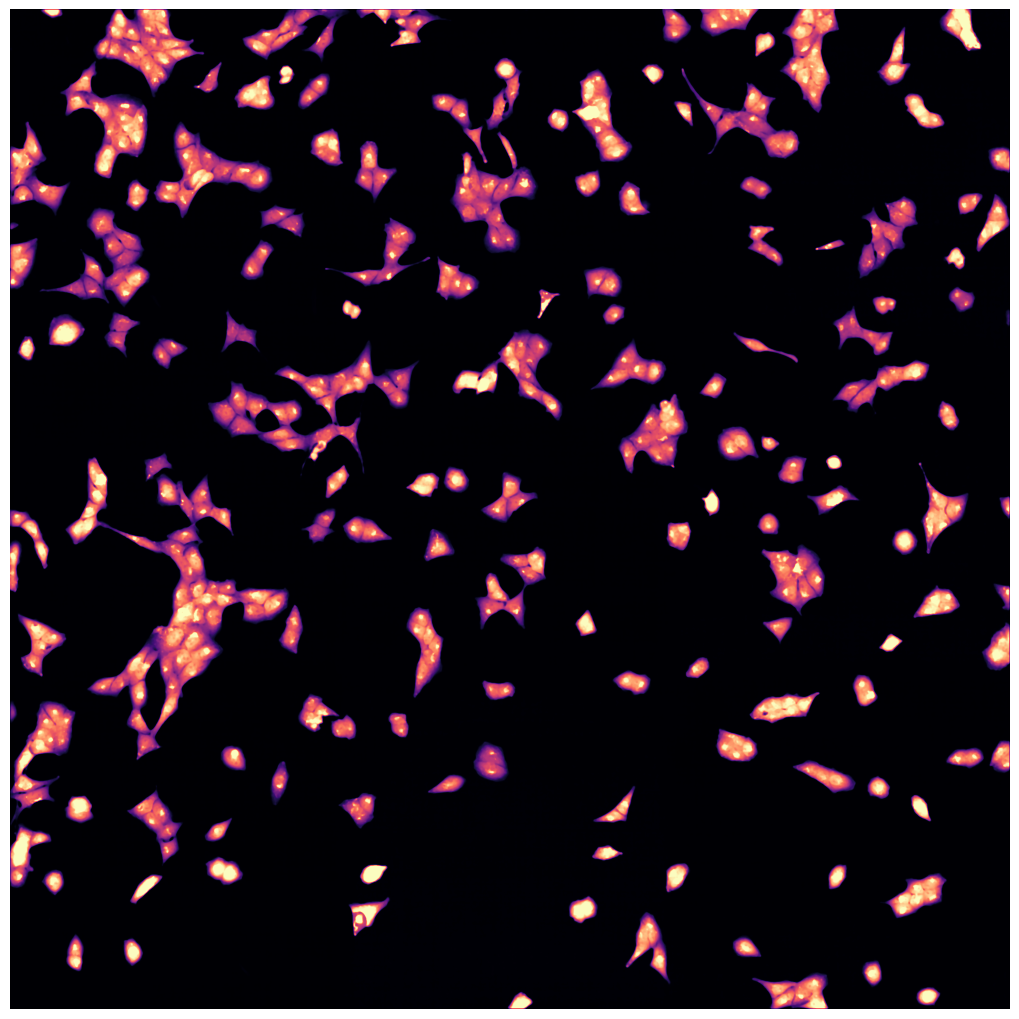

[12/07/2024 15:01:01] Median map created


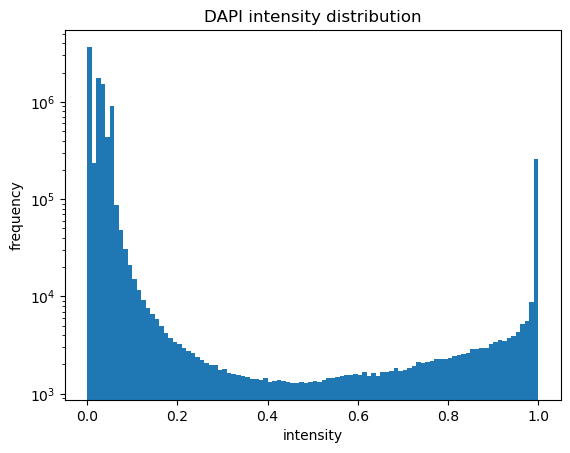

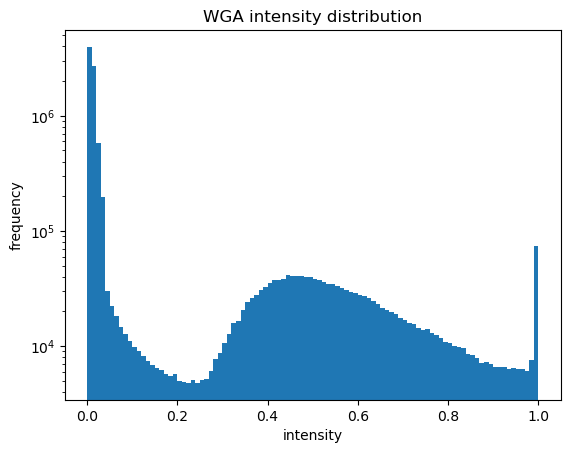

[12/07/2024 15:01:01] Started performing nucleus segmentation.
[12/07/2024 15:01:01] Generating thresholded nucleus map.


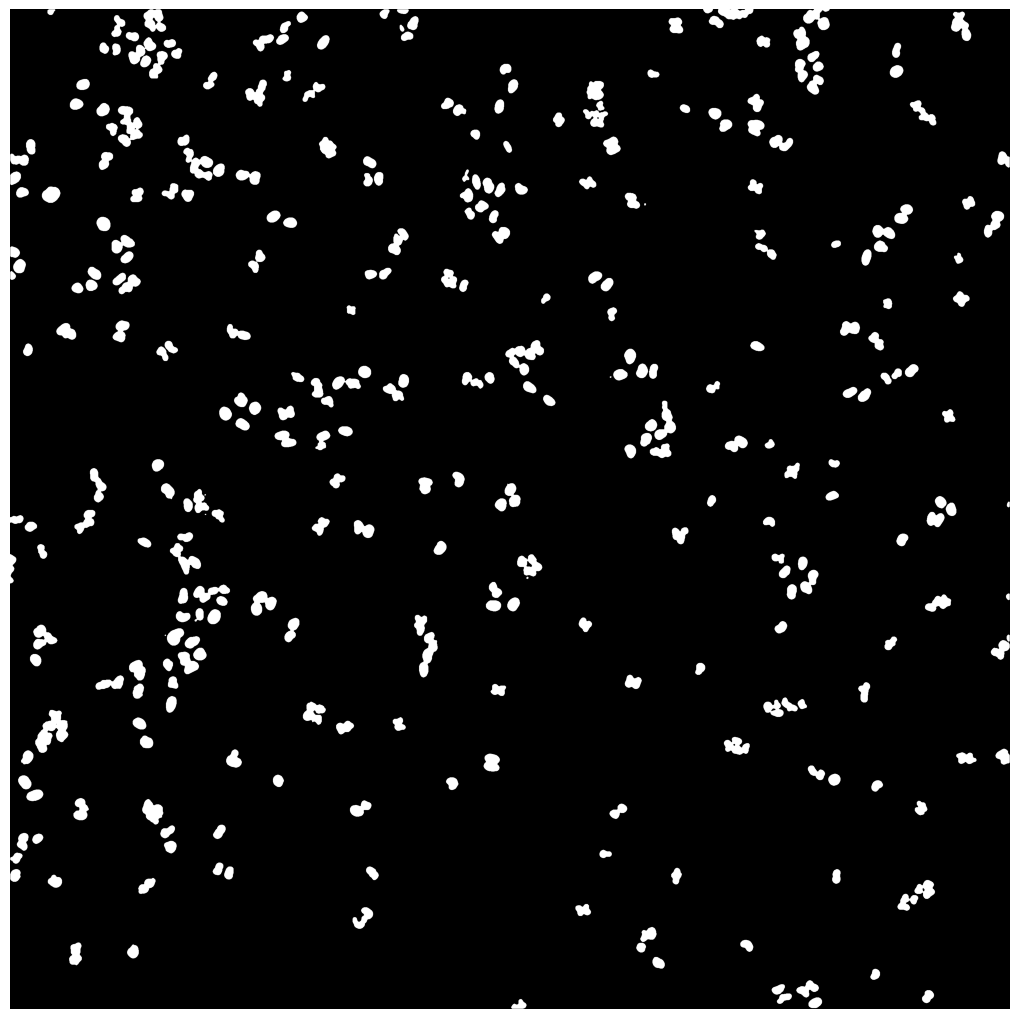

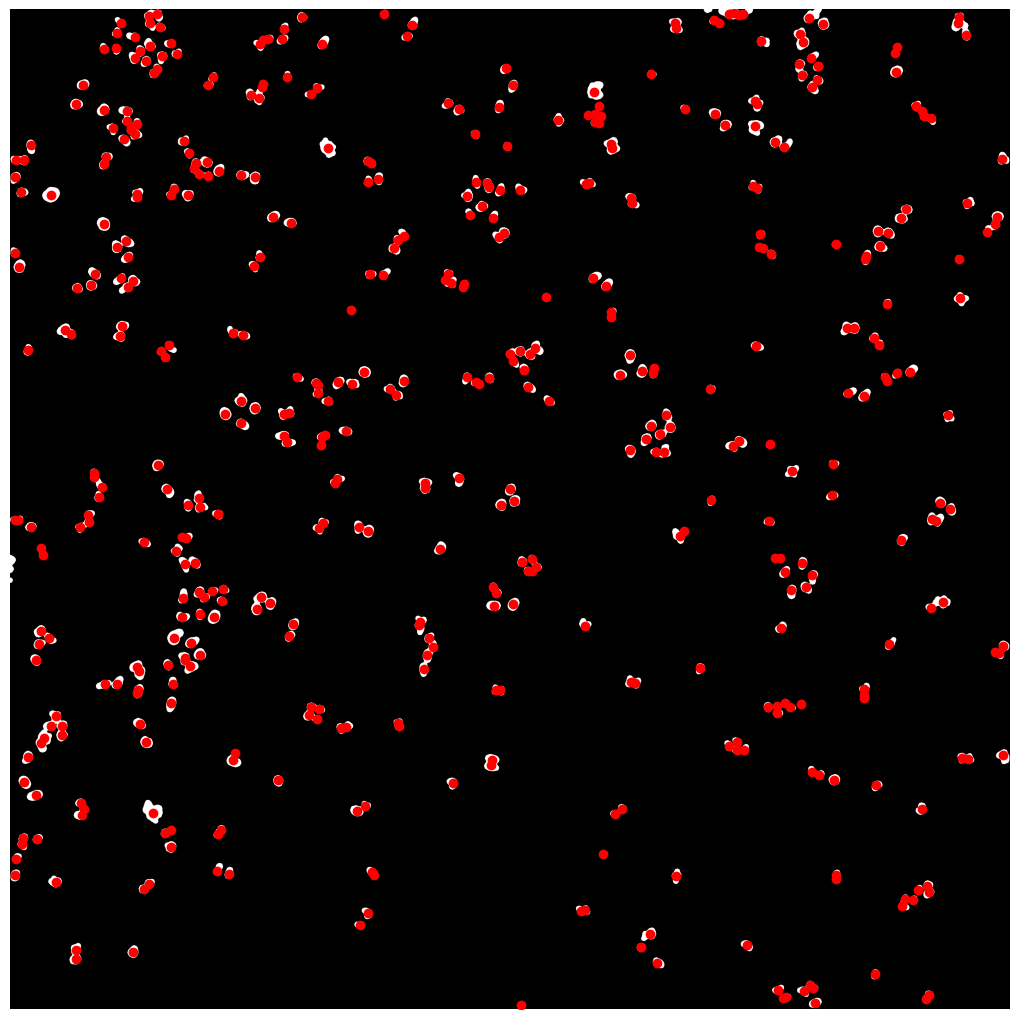

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


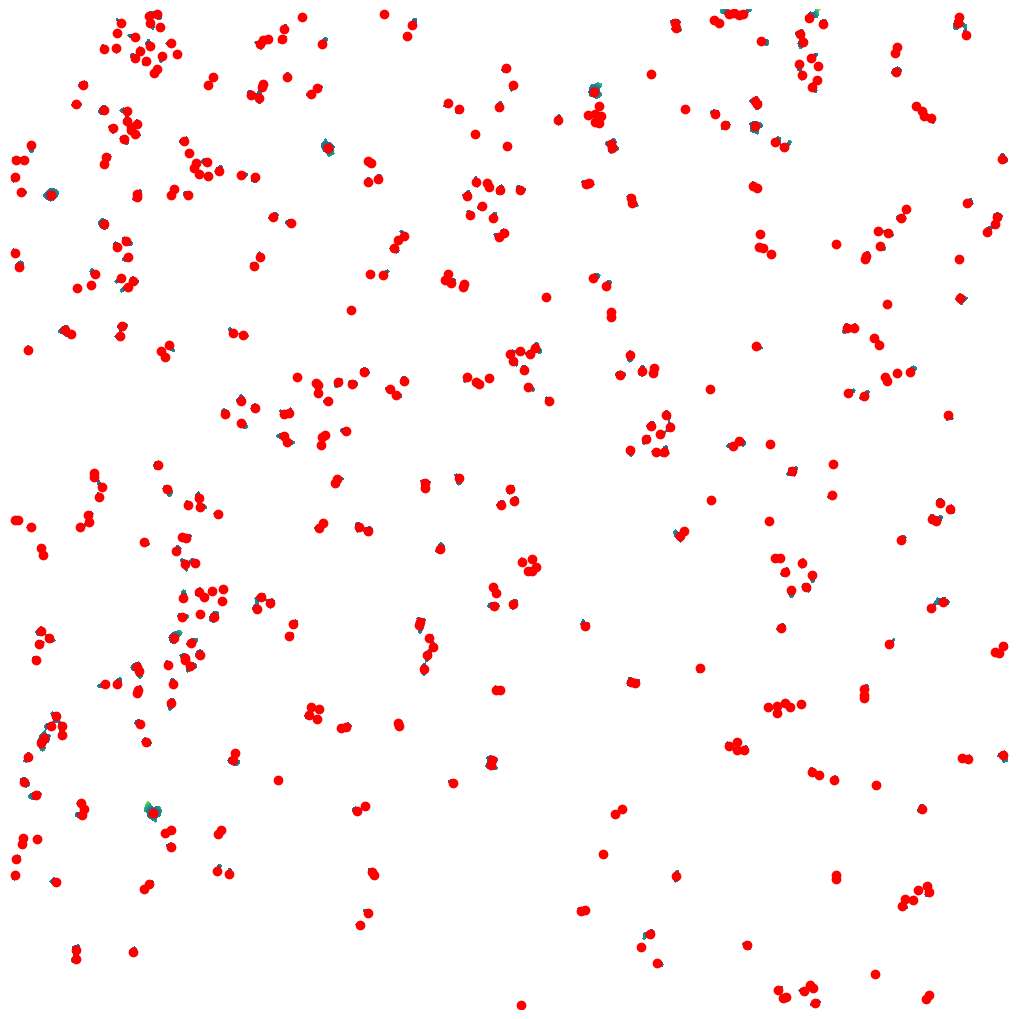

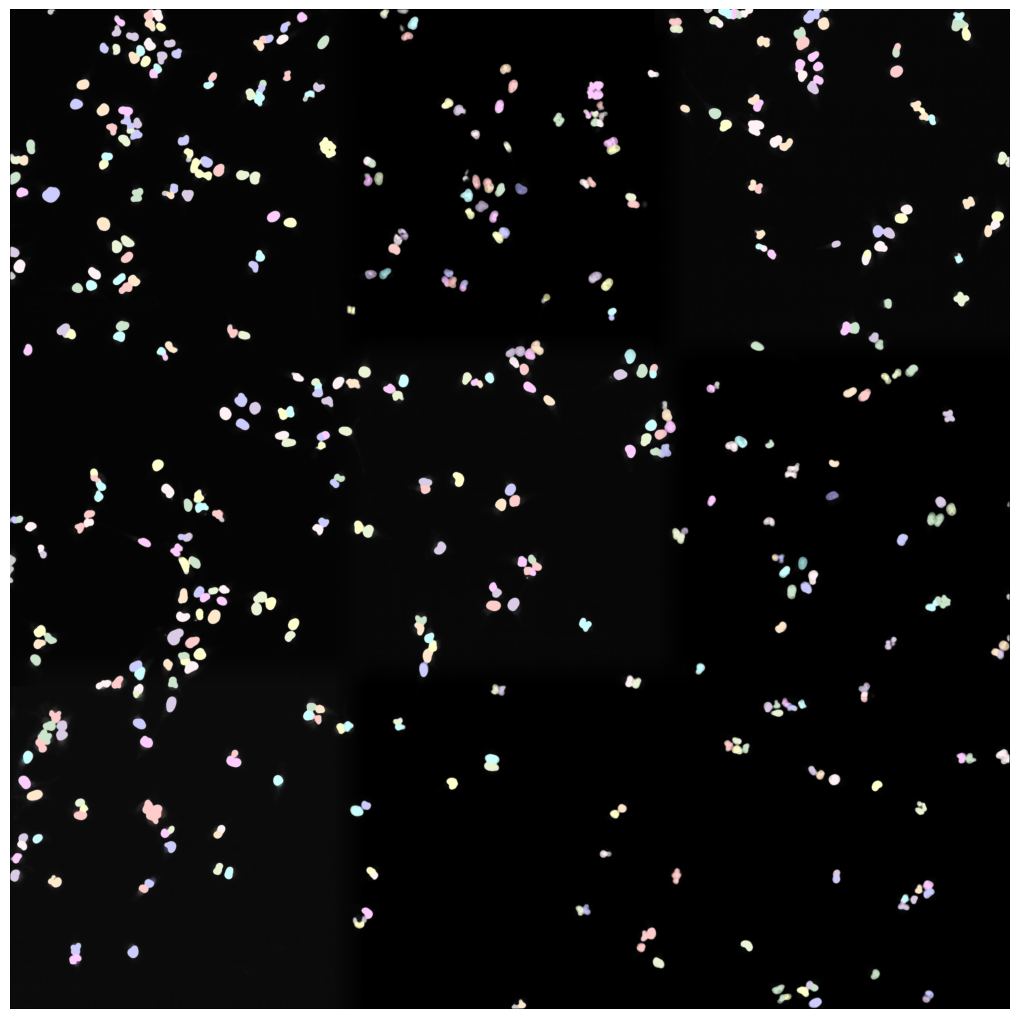

[12/07/2024 15:01:15] /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/2_nucleus_segmentation_map will be saved as tif


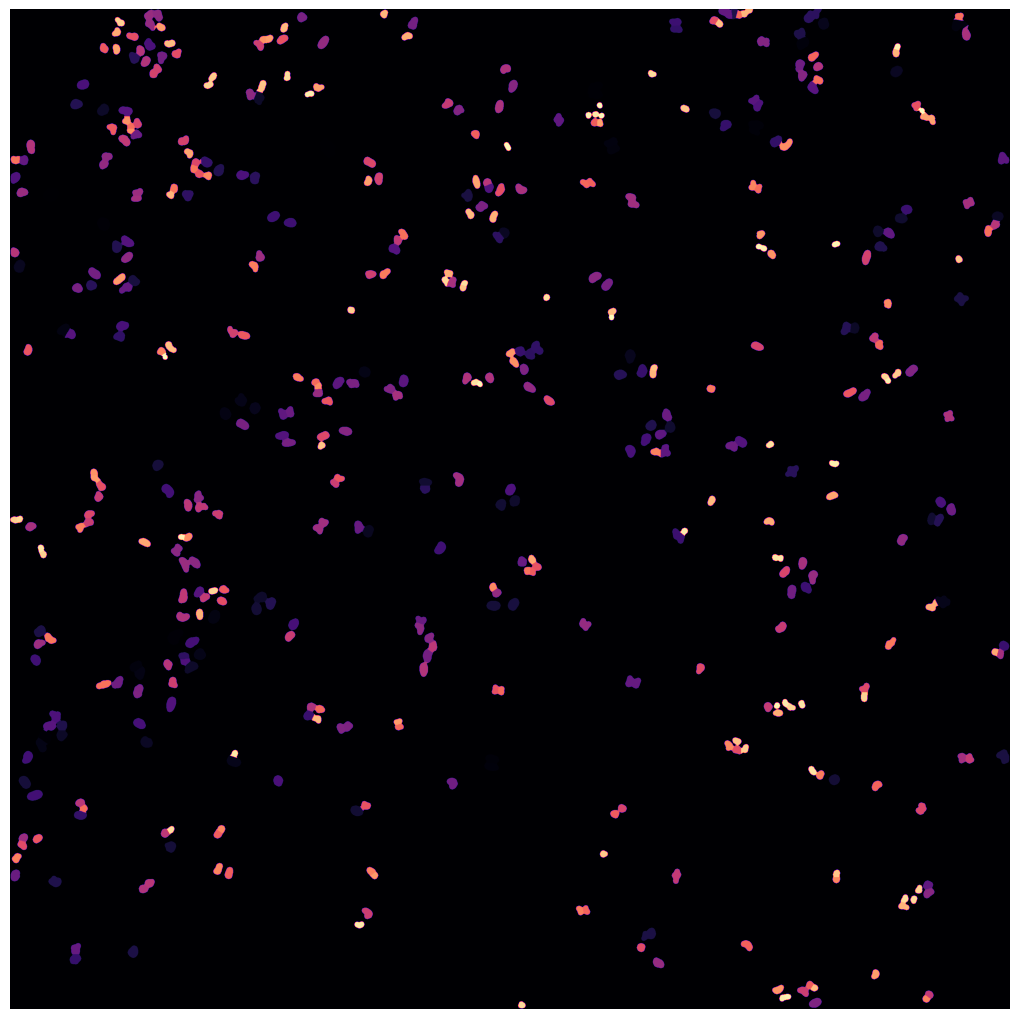

[12/07/2024 15:01:15] Thresholded nucleus map created.
[12/07/2024 15:01:15] Started with nucleus mask map
[12/07/2024 15:01:15] /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/3_nucleus_mask_map will be saved as tif


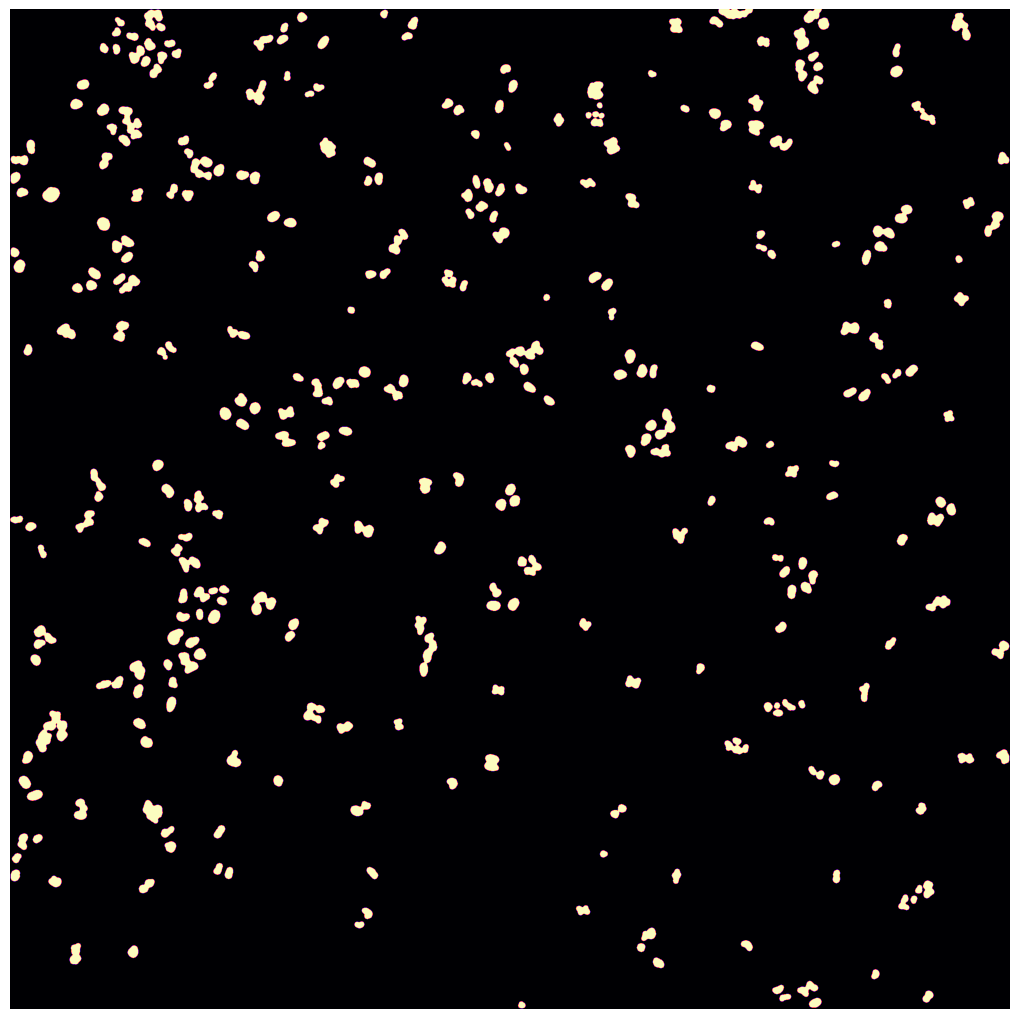

[12/07/2024 15:01:15] Nucleus mask map created with 494 elements
[12/07/2024 15:01:18] Filtered out due to contact limit: 10 
[12/07/2024 15:01:19] Filtered out due to size limit: 0 
[12/07/2024 15:01:19] Filtered out: 10 


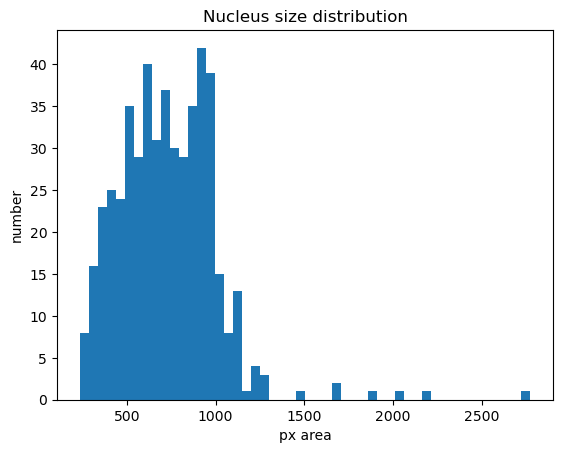

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


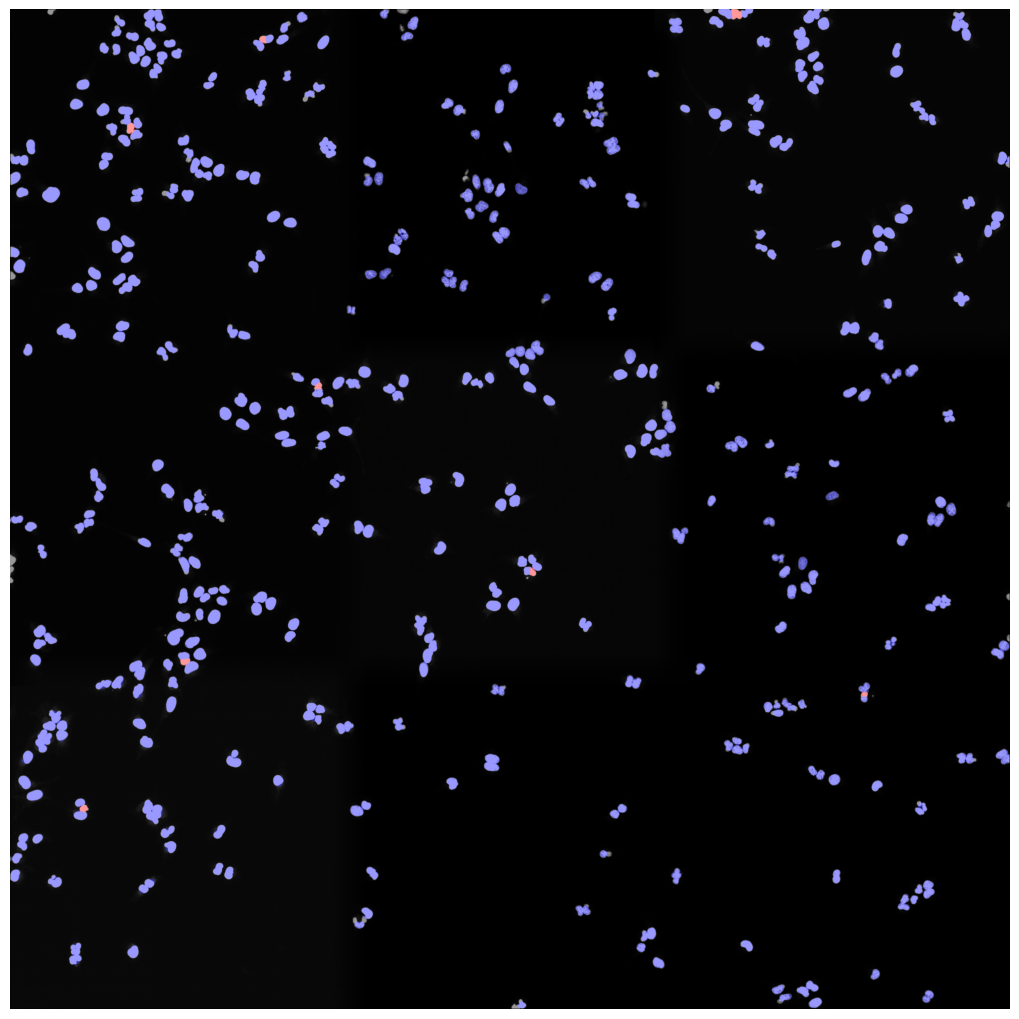

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


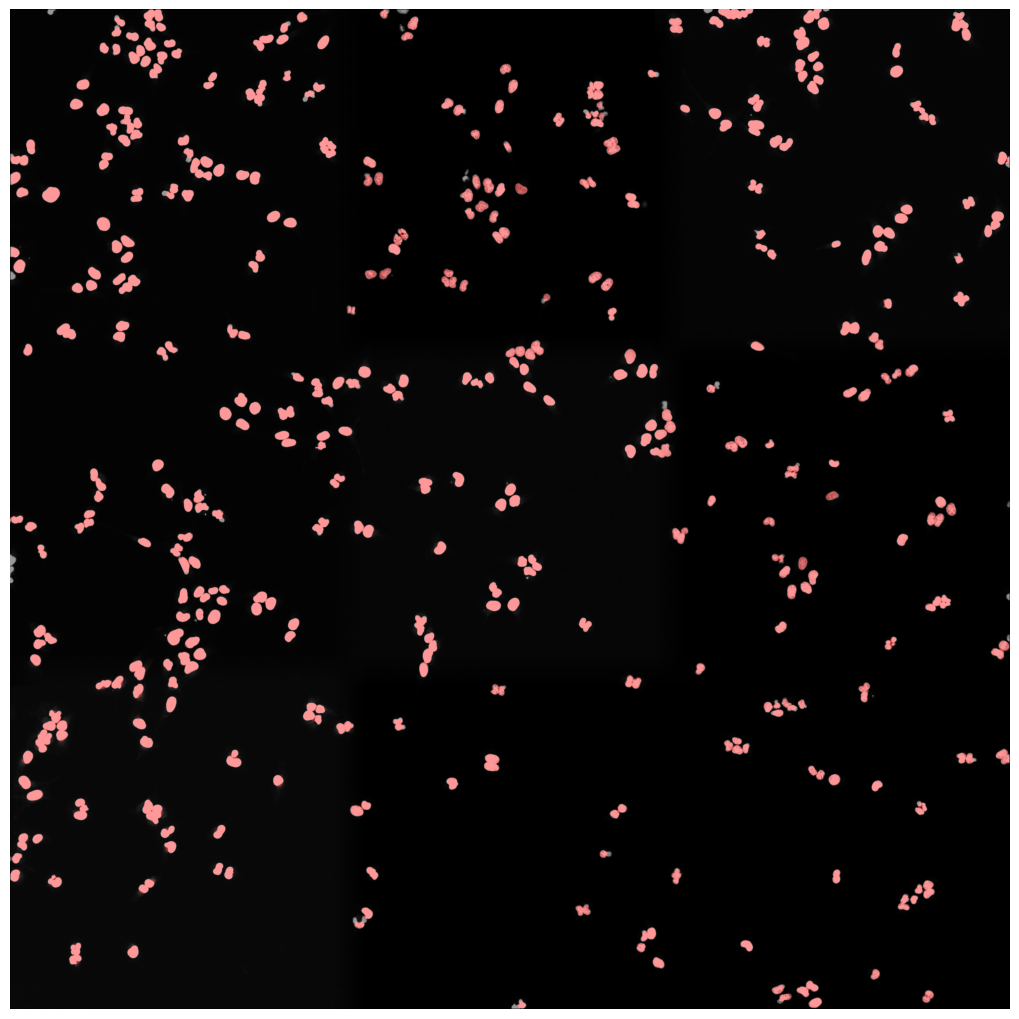

[12/07/2024 15:01:21] Started with WGA mask map


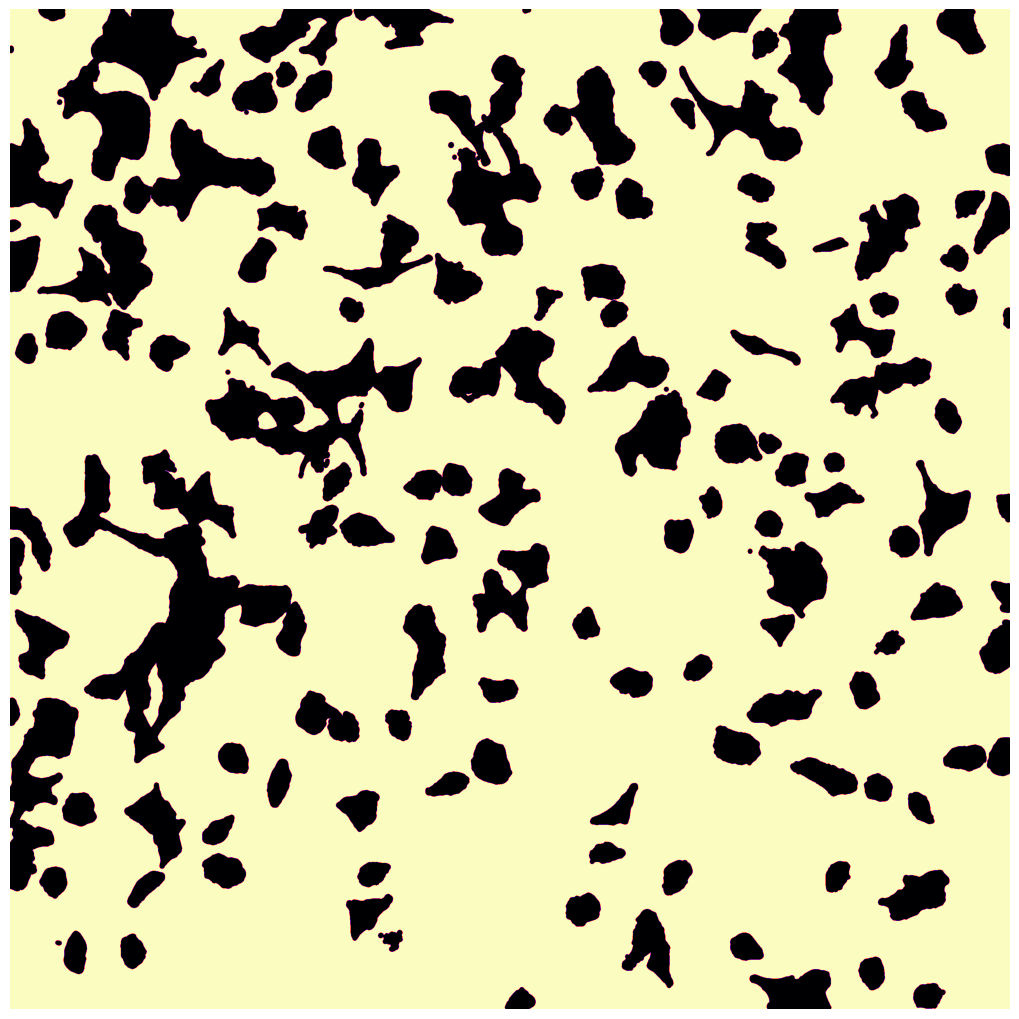

[12/07/2024 15:01:22] WGA mask map created
[12/07/2024 15:01:22] Started with WGA potential map


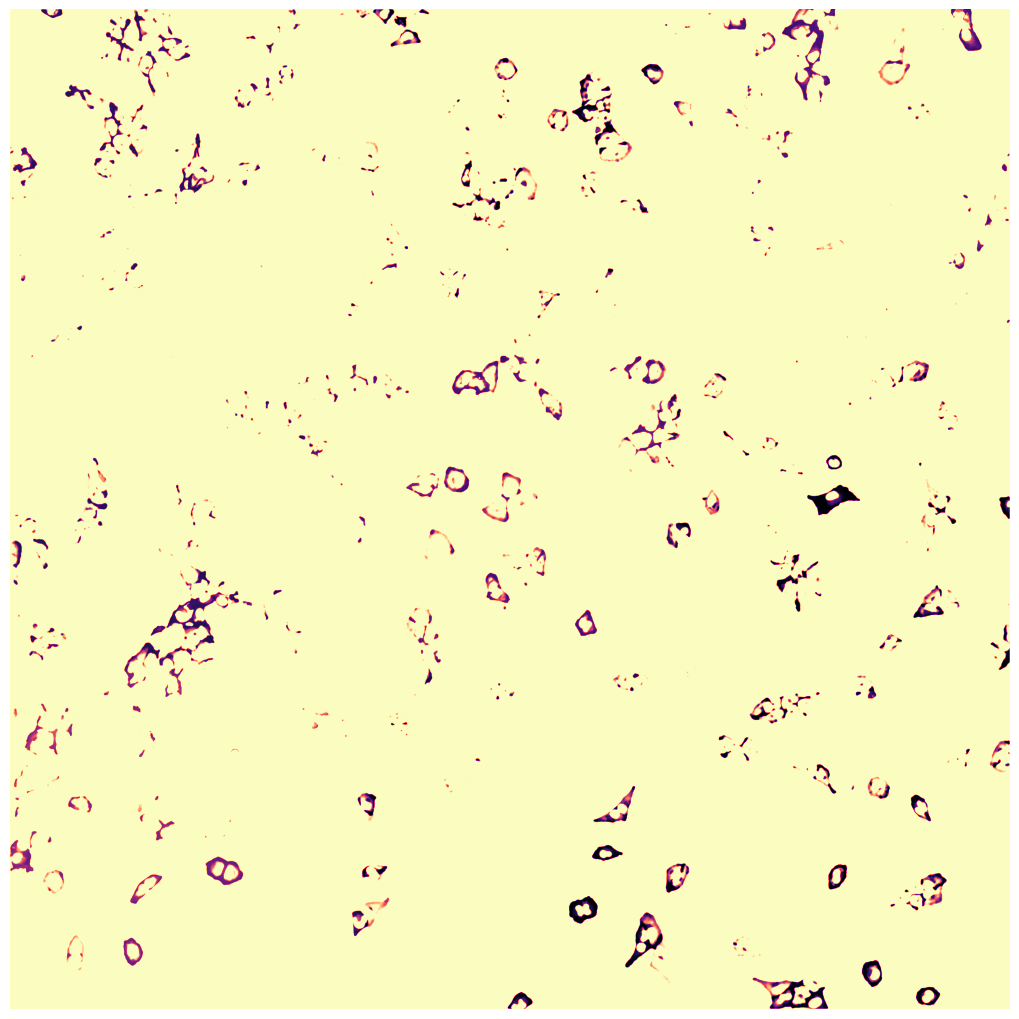

[12/07/2024 15:01:23] WGA mask potential created
[12/07/2024 15:01:23] Started with fast marching


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/workflows.py:271: RuntimeWarning: invalid value encountered in cast
  px_center = np.round(center_nuclei).astype(np.uint64)


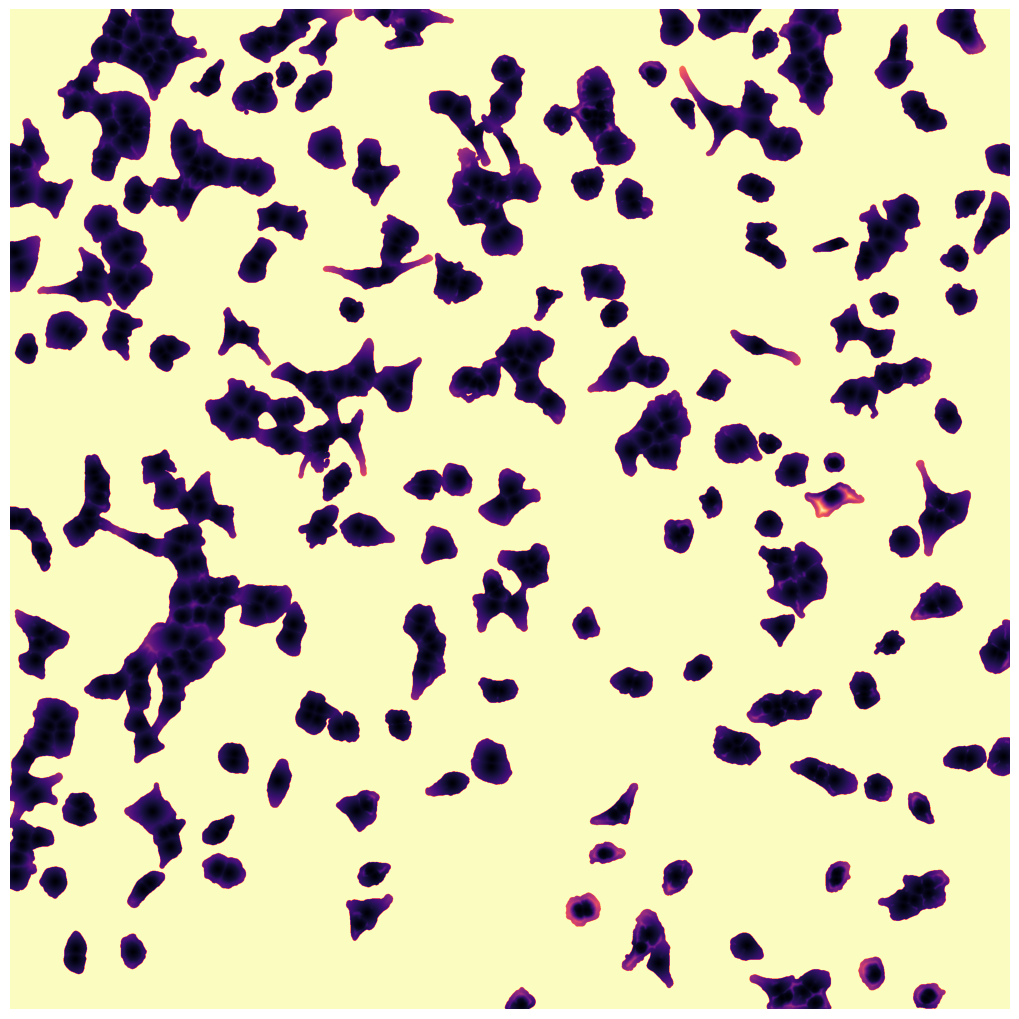

[12/07/2024 15:01:24] Fast marching finished
[12/07/2024 15:01:24] Started with watershed


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/workflows.py:293: RuntimeWarning: invalid value encountered in cast
  px_center = np.round(center_nuclei).astype(np.uint64)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


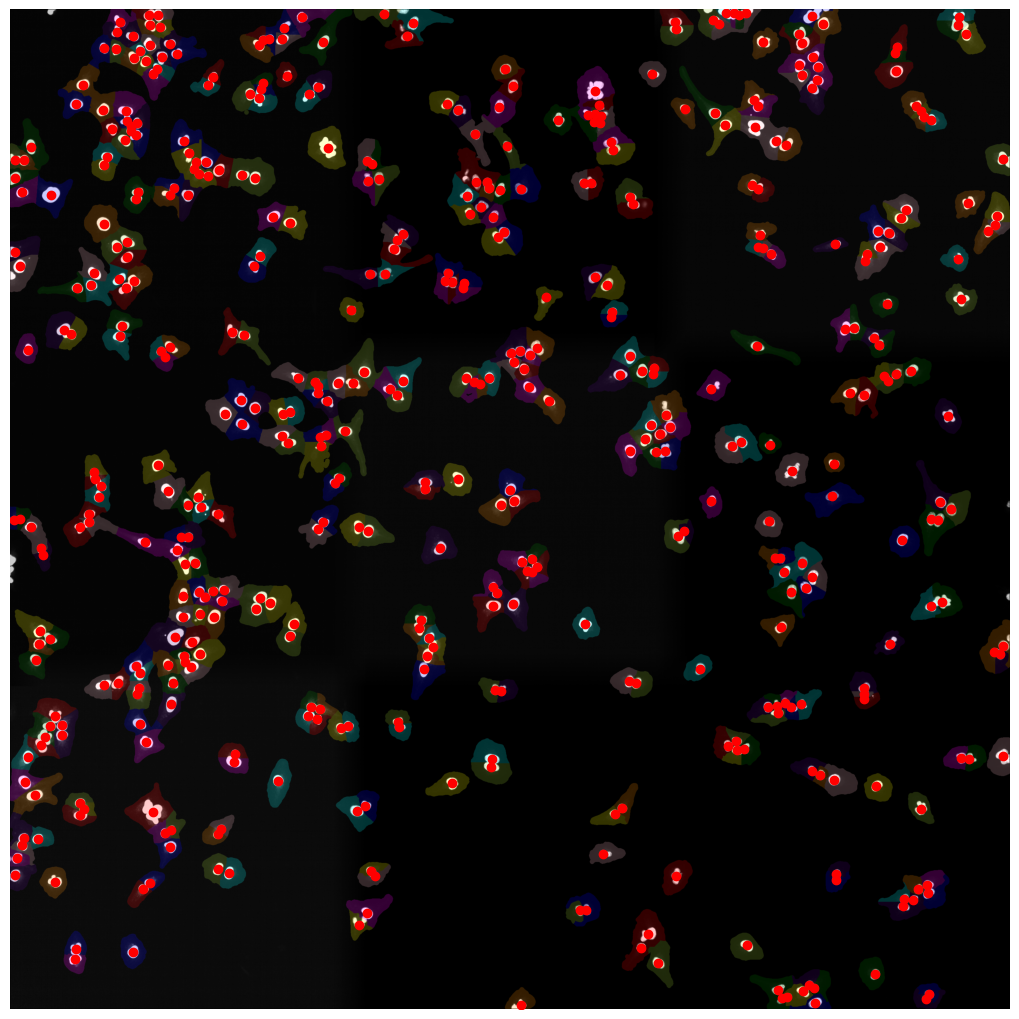

[12/07/2024 15:01:26] /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/7_watershed_map will be saved as tif


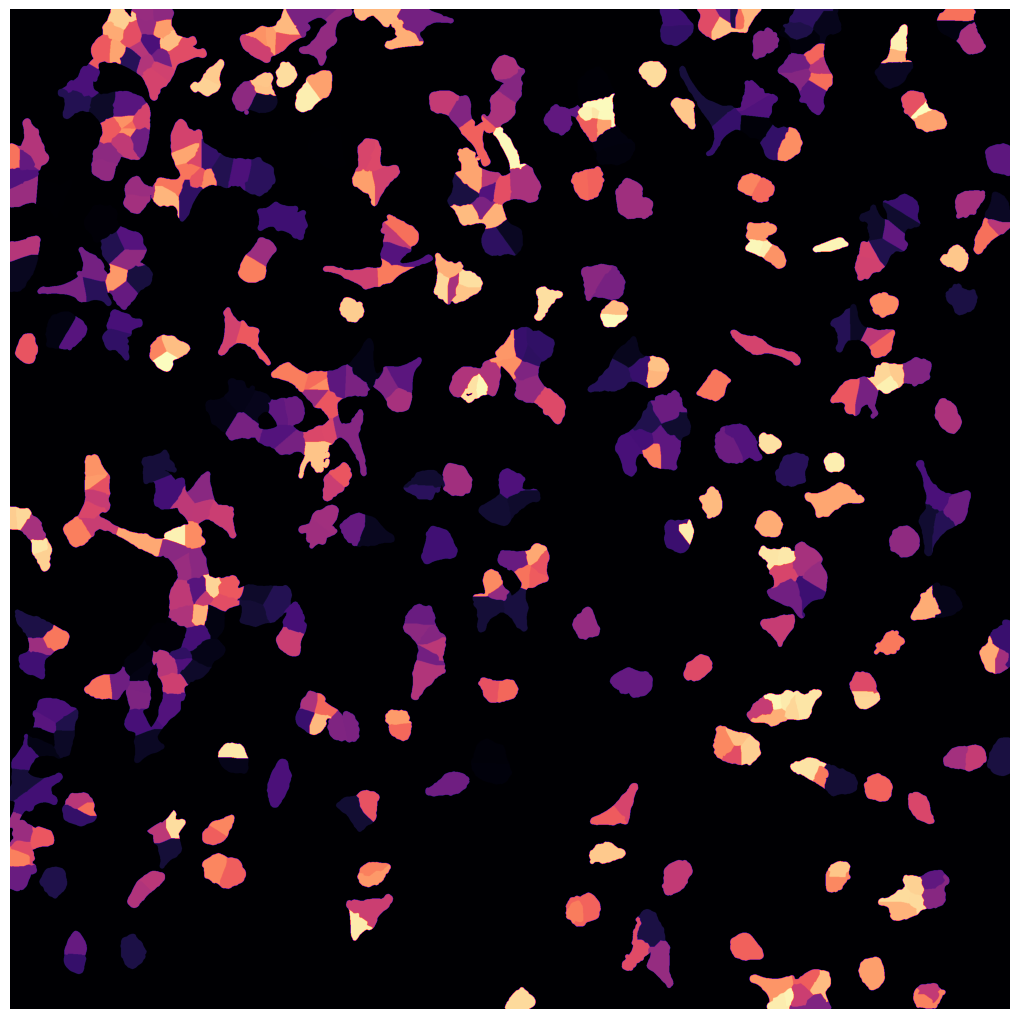

[12/07/2024 15:01:27] watershed finished
[12/07/2024 15:01:28] Cells filtered out due to cytosol size limit: 0 
[12/07/2024 15:01:28] Filtered out: 10 
[12/07/2024 15:01:28] Remaining: 485 


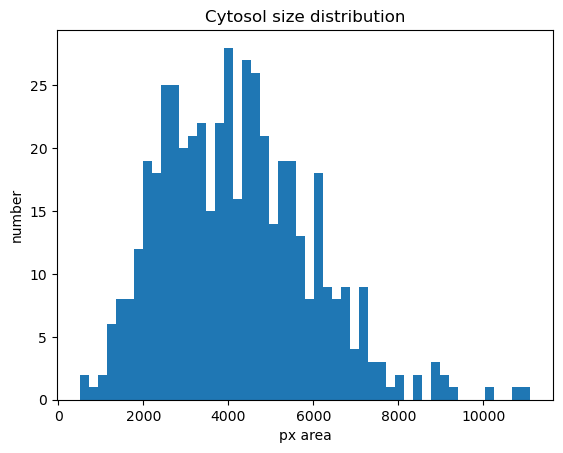

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


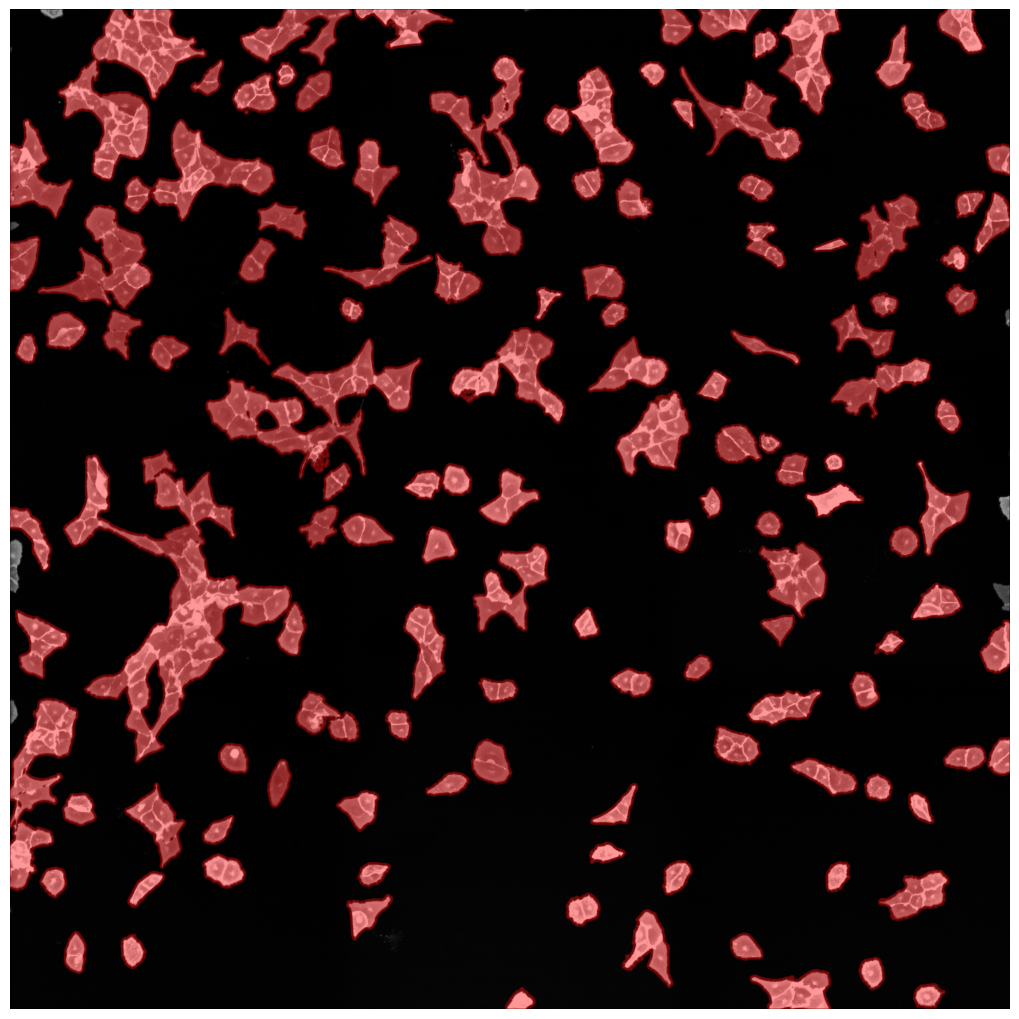

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


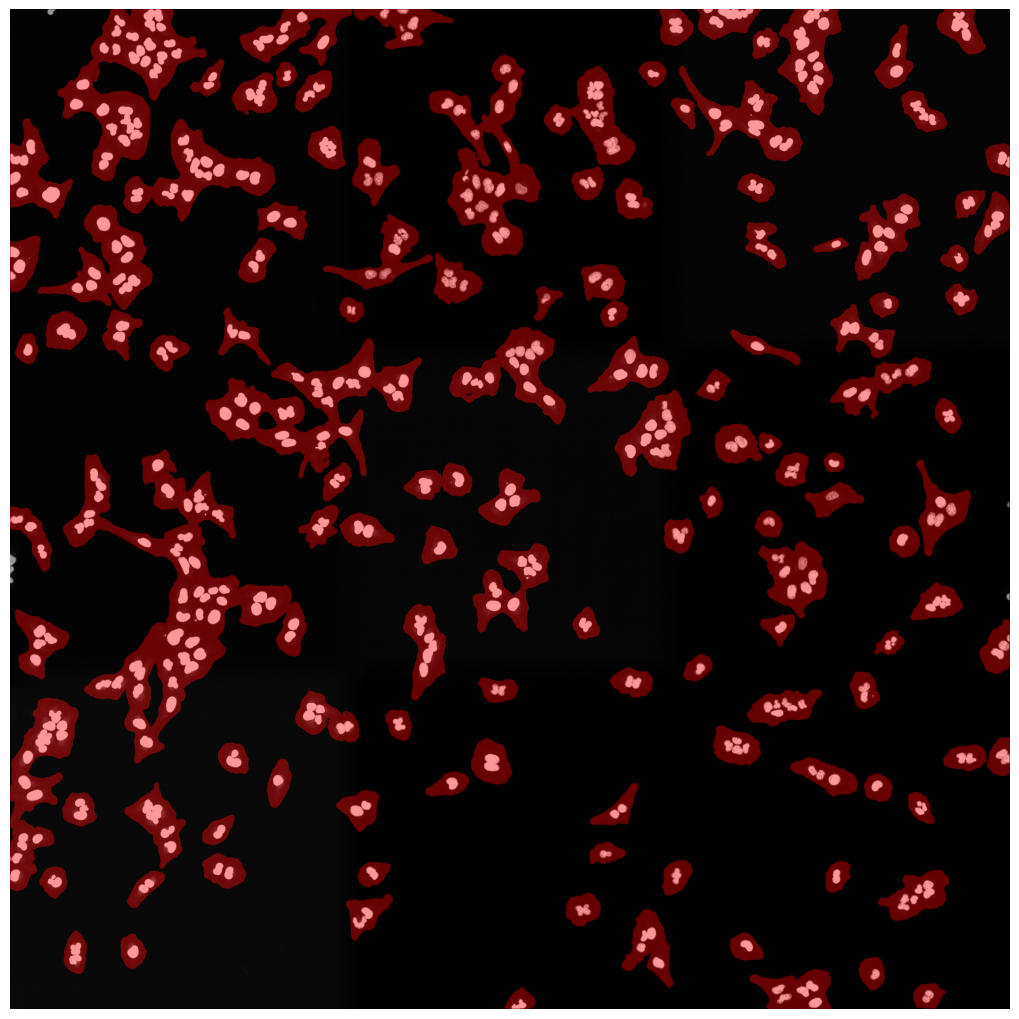

[12/07/2024 15:01:30] Filtering status for this segmentation is set to True.
[12/07/2024 15:01:30] Filtering has been performed during segmentation. Nucleus and Cytosol IDs match. No additional steps are required.
[12/07/2024 15:01:30] Saved cell_id classes to file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/classes.csv.
[12/07/2024 15:01:30] === finished segmentation ===
[12/07/2024 15:01:30] save_zarr attribute not found
[12/07/2024 15:01:30] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./WGASegmentation_raqzvqnq'>


In [7]:
project.segment(debug = True)

### Looking at Segmentation Results

The Segmentation Results are written to a hdf5 file called `segmentation.h5` located in the segmentation directory of our SPARCSpy project.

The file contains two datasets: `channels` and `labels`. Channels contains the input images and `labels` the generated segmentation masks.

In [8]:
import h5py

with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    print(hf.keys())


<KeysViewHDF5 ['channels', 'labels']>


If we look at the `labels` dataset we can see that it contains a numpy array containing two segmentation masks: the nuclear segmentation and the cytosol segmentation generated by our chosen segmentation method.

<HDF5 dataset "labels": shape (2, 3040, 3038), type "<u4">


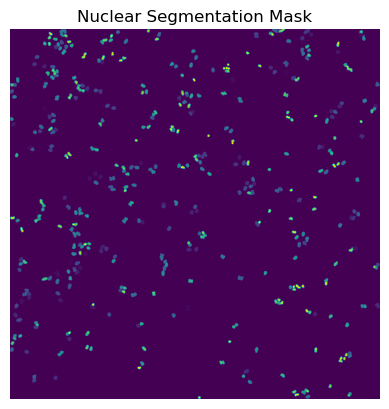

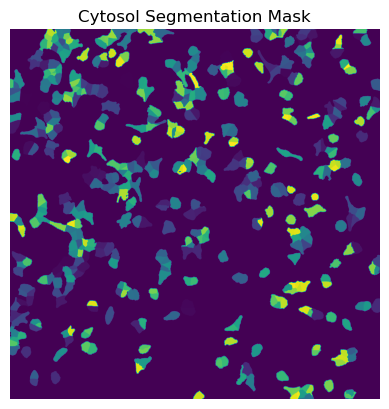

In [9]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")
    print(segmentation)

    plt.figure()
    plt.imshow(segmentation[0])
    plt.axis("off")
    plt.title("Nuclear Segmentation Mask")

    plt.figure()
    plt.imshow(segmentation[1])
    plt.axis("off")
    plt.title("Cytosol Segmentation Mask")


Each segmentation mask is an array where each pixel is assigned either to background (`0`) or to a specific cell (`cellid: whole number`).

If we zoom in on the corner of the segmentation mask of a nucleus the numpy array would look like this:

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 205]
 [  0   0   0   0   0   0   0 205 205 205]
 [  0   0   0   0   0   0 205 205 205 205]
 [  0   0   0   0 205 205 205 205 205 205]
 [  0   0   0 205 205 205 205 205 205 205]
 [  0   0 205 205 205 205 205 205 205 205]
 [  0 205 205 205 205 205 205 205 205 205]
 [205 205 205 205 205 205 205 205 205 205]]


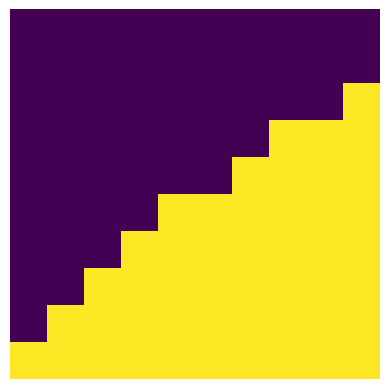

In [10]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")

    plt.imshow(segmentation[0, 80:90, 945:955])
    plt.axis("off")
    print(segmentation[0, 80:90, 945:955])


## Extracting single-cell images

Once we have generated a segmentation mask, the next step is to extract single-cell images of segmented cells in the dataset.

Like during the segmentation there are several extraction methods to choose from. For regular SPARCSpy projects we need the `HDF5CellExtraction` method. This will extract single-cell images for all cells segmentated in the dataset and write them to a hdf5 file.

The parameters with which `HDF5CellExtraction` will run are again specified in the `config.yml` file.

                HDF5CellExtraction:
                    compression: True
                    threads: 80 # threads used in multithreading
                    image_size: 128 # image size in pixel
                    cache: "."
                    hdf5_rdcc_nbytes: 5242880000 # 5gb 1024 * 1024 * 5000 
                    hdf5_rdcc_w0: 1
                    hdf5_rdcc_nslots: 50000

[12/07/2024 15:01:31] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_2mzgd9af for HDF5CellExtraction
[12/07/2024 15:01:31] Using channel label <HDF5 dataset "channels": shape (3, 3040, 3038), type "<f8">
[12/07/2024 15:01:31] Using segmentation label <HDF5 dataset "labels": shape (2, 3040, 3038), type "<u4">
[12/07/2024 15:01:31] Created new data directory /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/extraction/data
[12/07/2024 15:01:31] Setup output folder at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/extraction/data
[12/07/2024 15:01:31] Started extraction
[12/07/2024 15:01:31] Loading segmentation data from /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/segmentation.h5
[12/07/2024 15:01:31] Finished loading channel data (3, 3040, 3038)
[12/07/2024 15:01:31] Finished loading label data (2, 3040, 3038)
[12/07/2024 15:01:31]

Processing cell batches:   0%|          | 0/70 [00:00<?, ?it/s]

cell id 108 is too close to the image edge to extract. Skipping this cell.
cell id 101 is too close to the image edge to extract. Skipping this cell.cell id 199 is too close to the image edge to extract. Skipping this cell.cell id 214 is too close to the image edge to extract. Skipping this cell.cell id 27 is too close to the image edge to extract. Skipping this cell.cell id 125 is too close to the image edge to extract. Skipping this cell.cell id 174 is too close to the image edge to extract. Skipping this cell.cell id 54 is too close to the image edge to extract. Skipping this cell.cell id 262 is too close to the image edge to extract. Skipping this cell.
cell id 207 is too close to the image edge to extract. Skipping this cell.
cell id 97 is too close to the image edge to extract. Skipping this cell.cell id 90 is too close to the image edge to extract. Skipping this cell.cell id 168 is too close to the image edge to extract. Skipping this cell.

cell id 249 is too close to the image

/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/extraction.py:333: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


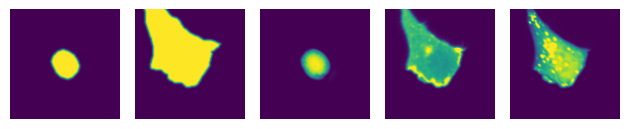

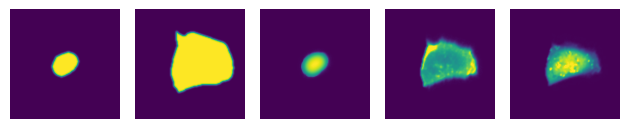

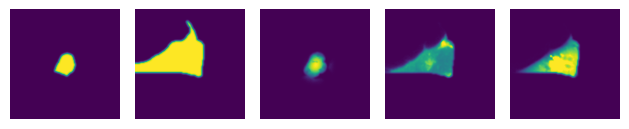

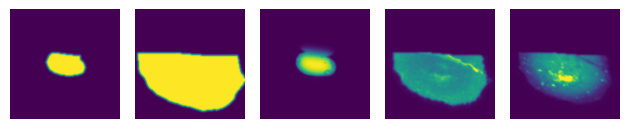

In [11]:
project.extract()

### Look at extracted single-cell images

The extracted single-cell images are written to a h5py file `single_cells.h5` located under `extraction\data` within the project folder.

The file contains two datasets: `single_cell_data` and `single_cell_index`. `single_cell_data` contains the extracted single cell images while `single_cell_index` contains the cell id of the extracted cell at that location.

In [12]:
import h5py

with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    print(hf.keys())


<KeysViewHDF5 ['single_cell_data', 'single_cell_index']>


So if we want to look at the nth cell in the dataset we can first check which cellid was assigned to this cell by looking at the nth entry in the `single_cell_index` dataset and then get the extracted single-cell images from the `single_cell_data` dataset.

The extracted single-cell images represent the following information in this order:  
<ol>
1. nucleus mask<br>
                2. cytosol mask  <br>
                3. nucleus channel <br> 
                4. cytosol channel <br> 
                5. other channels<br>
</ol> 

Here we will demonstrate with the 10th cell in the dataset.

cell id:  [10 11]


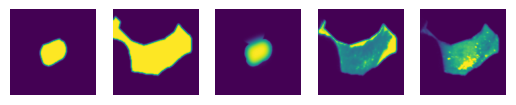

In [13]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print("cell id: ", index[10])

    image = images[10]

    fig, axs = plt.subplots(1, 5)

    for i, _img in enumerate(image):
        axs[i].imshow(_img)
        axs[i].axis("off")

## Classification of extracted single-cells

Next we can apply a pretained model to classify our cells within the SPARCSpy project. 

Within the `config.yml` we specify which model should be used for inference and we can give it a name. 

                MLClusterClassifier:
                    channel_classification: 4
                    threads: 24 #
                    batch_size: 900
                    dataloader_worker: 0 #needs to be 0 if using cpu
                    standard_scale: False
                    exp_transform: False
                    log_transform: False
                    network: "autophagy_classifier2.1"
                    classifier_architecture: "VGG2_old"
                    screen_label: "Autophagy_15h_classifier2.1"
                    epoch: "max"
                    encoders: ["forward"]
                    inference_device: "cpu"

Here e.g. we are using a pretrained model included within the SPARCSpy library `autophagy_classifier2.1` and are naming the results from this model `Autophagy_15h_classifier2.1`. 

Model overview:

<img src="../images/classifying_autophagy.png" alt="autophagy classification with example cells" width="800"/>


The inference results will be written to a new folder generated under `classification` with this name. 

If we want to use a model we trained ourselves that is not yet included within the SPARCSpy library we can simply replace the network name in the config with the path to the checkpoint file generated by pytorch.


In [14]:
accessory = ([], [], [])
project.classify(accessory = accessory)

[12/07/2024 15:01:34] Started classification
[12/07/2024 15:01:34] starting with run 0
[12/07/2024 15:01:34] channel_classification: 4
[12/07/2024 15:01:34] threads: 24
[12/07/2024 15:01:34] batch_size: 900
[12/07/2024 15:01:34] dataloader_worker_number: 0
[12/07/2024 15:01:34] standard_scale: False
[12/07/2024 15:01:34] exp_transform: False
[12/07/2024 15:01:34] log_transform: False
[12/07/2024 15:01:34] network: autophagy_classifier2.1
[12/07/2024 15:01:34] classifier_architecture: VGG2_old
[12/07/2024 15:01:34] screen_label: Autophagy_15h_classifier2.1
[12/07/2024 15:01:34] epoch: max
[12/07/2024 15:01:34] encoders: ['forward']
[12/07/2024 15:01:34] inference_device: cpu
[12/07/2024 15:01:34] 0 different accessory datasets specified


Lightning automatically upgraded your loaded checkpoint from v1.5.5 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../src/pretrained_models/autophagy/autophagy2.1/VGG2_autophagy_classifier2.1.cpkt`


[12/07/2024 15:01:34] model parameters loaded from autophagy_classifier2.1
[12/07/2024 15:01:34] loading /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/extraction/data
[12/07/2024 15:01:34] Adding hdf5 file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/extraction/data/single_cells.h5 to index...
Total: 432
0: 432

[12/07/2024 15:01:34] Start processing 1 batches with forward based inference
[12/07/2024 15:01:37] finished processing


### looking at the generated results

The results are written to a csv file which we can load with pandas.

SPARCSpy writes the softmax results directly to csv as `ln()` for better precision. To transform these numbers back to the range between 0 and 1 we first need to apply the `np.exp` function.

In [15]:
results = pd.read_csv(f"{project_location}/classification/0_Autophagy_15h_classifier2.1/dimension_reduction_forward.csv", index_col = 0)
results.result_0 = np.exp(results.result_0)
results.result_1 = np.exp(results.result_1)

results

result_0  result_1  label  cell_id
0    0.000088  0.999912      0      104
1    0.000023  0.999977      0      256
2    0.613948  0.386052      0      397
3    0.998168  0.001832      0      228
4    0.000513  0.999486      0      387
..        ...       ...    ...      ...
427  0.000108  0.999892      0      451
428  0.047010  0.952990      0      331
429  0.000008  0.999992      0      180
430  0.000007  0.999993      0      370
431  0.069439  0.930561      0      166

[432 rows x 4 columns]

Depending on the model we used what `result_0` and `result_1` represent will vary. Here we used a binary classification model were class 1 was cells deficient in autophagy. So `result_1` indicates the probability score that a cell has the label "autophagy off". `results_0` is simply `1 - result_1`


If we look at the distribution in our dataset we can see that almost all cells are classified as "autophagy defective". Since the input images were from unstimulated wt cells this matches to our expectation.

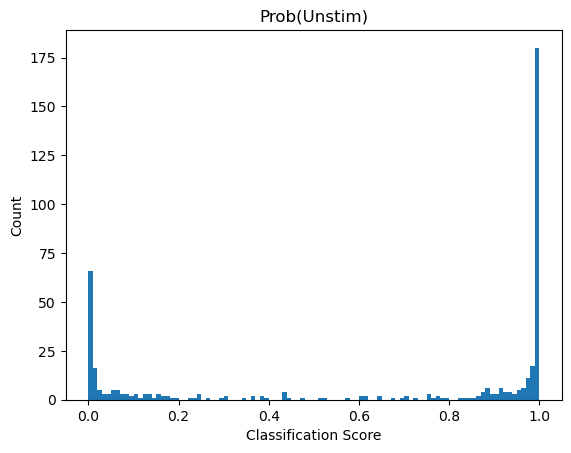

In [16]:
plt.hist(results.result_1, bins = 100);
plt.title("Prob(Unstim)");
plt.xlabel("Classification Score");
plt.ylabel("Count");

## Exporting Cutting contours for excision on the LMD7

SPARCSpy directly interfaces with our other open-source python library [py-lmd](https://github.com/MannLabs/py-lmd) to easily select and export cells for excision on a Leica LMD microscope. 

Of note: this will require that the cells have been plates on a LMD compatible surface (like a PPS slide). SPARCSpy can of course also simply be used for data analysis procedures, then ignore this last step.

First we will select the cells we wish to excise based on their classification score. Here we have chosen a threadhold >= 0.99999 for bin1 and a threshold <= 0.9 for bin2. 

In [17]:
cell_ids_bin1 = results[results.result_1 >= 0.99999].cell_id.tolist()
cell_ids_bin2 = results[results.result_1 <= 0.9].cell_id.tolist()

print("number of cells to excise:",len(cell_ids_bin1) + len(cell_ids_bin2))

number of cells to excise: 221


The cells can then be allocated into different wells.

In [18]:
cells_to_select = [{"name": "bin1", "classes": list(cell_ids_bin1), "well":"A1"},
                   {"name": "bin2", "classes": list(cell_ids_bin2), "well":"B1"},
                   ]

In addition to defining which cells we want to excise, we also need to pass the location of the calibration crosses so that we can transfer the image coordinate system into a cutting coordinate system. You can read up on this [here](https://mannlabs.github.io/py-lmd/html/pages/segmentation_loader.html#different-coordinate-systems).

To obtain the coordinates of your reference points simply open your stitched image in e.g. FIJI and navigate to the location of your reference points. Then write out the coordinates for each point.

In [19]:
marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])

As with the previous methods, additional parameters can be passed to the selection function via the `config.yml` file which adapts the behaviour of how cutting shapes are generated. You can read up more on this [here](https://mannlabs.github.io/py-lmd/html/pages/segmentation_loader.html#overview-of-configuration).

                LMDSelection:
                    processes: 20

                    # defines the channel used for generating cutting masks
                    # segmentation.hdf5 => labels => segmentation_channel
                    # When using WGA segmentation:
                    #    0 corresponds to nuclear masks
                    #    1 corresponds to cytosolic masks.
                    segmentation_channel: 0

                    # dilation of the cutting mask in pixel
                    shape_dilation: 16

                    # number of datapoints which are averaged for smoothing
                    # the number of datapoints over an distance of n pixel is 2*n
                    smoothing_filter_size: 25

                    # fold reduction of datapoints for compression
                    poly_compression_factor: 30
                    
                    # can be "none", "greedy", or "hilbert"
                    path_optimization: "hilbert"
                    
                    # number of nearest neighbours for optimized greedy search
                    greedy_k: 15
                    
                    # hilbert curve order
                    hilbert_p: 7



[12/07/2024 15:01:37] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_57efnvdl for LMDSelection
[12/07/2024 15:01:37] Selection process started
No configuration for shape_erosion found, parameter will be set to 0
No configuration for binary_smoothing found, parameter will be set to 3
No configuration for convolution_smoothing found, parameter will be set to 15
No configuration for xml_decimal_transform found, parameter will be set to 100
No configuration for distance_heuristic found, parameter will be set to 300
No configuration for processes found, parameter will be set to 10
No configuration for join_intersecting found, parameter will be set to True
sanity check for cell set 0
cell set 0 passed sanity check
sanity check for cell set 1
cell set 1 passed sanity check
Calculating coordinate locations of all cells.
Processing cell sets in parallel


                  collecting cell sets:   0%|          | 0/2 [00:00<?, ?it/s]

Convert label format into coordinate format
Convert label format into coordinate format
Conversion finished, performing sanity check.
Check passed
Check passed
Check passed
Conversion finished, performing sanity check.
Check passed
Check passed
Check passed


 48%|████▊     | 92/193 [00:01<00:01, 83.73it/s]

Create shapes for merged cells


100%|██████████| 193/193 [00:01<00:00, 105.97it/s]it/s]


Create shapes for merged cells


creating shapes: 100%|██████████| 26/26 [00:01<00:00, 14.79it/s]


Calculating polygons


creating shapes: 100%|██████████| 89/89 [00:02<00:00, 31.65it/s]


Calculating polygons


calculating polygons: 100%|██████████| 26/26 [00:03<00:00,  8.38it/s]


Polygon calculation finished
Current path length: 38,763.07 units
Path optimizer defined in config: hilbert
Optimized path length: 38,763.07 units
Optimization factor: 1.0x
Figure(1000x1000)


calculating polygons: 100%|██████████| 89/89 [00:02<00:00, 32.65it/s]


Polygon calculation finished
Current path length: 129,337.32 units
Path optimizer defined in config: hilbert
Optimized path length: 129,337.32 units
Optimization factor: 1.0x
Figure(1000x1000)


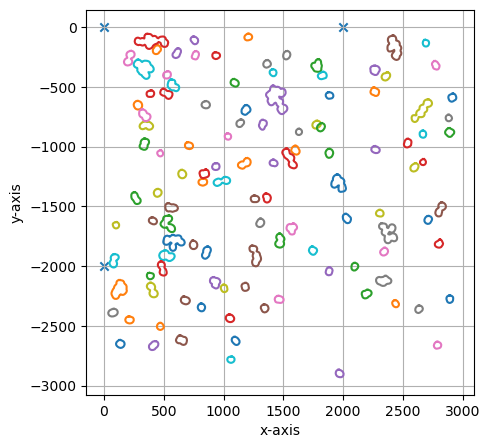

===== Collection Stats =====
Number of shapes: 115
Number of vertices: 2,716
Mean vertices: 24
Min vertices: 14
5% percentile vertices: 15
Median vertices: 19
95% percentile vertices: 50
Max vertices: 73
[0 0]
[      0 -200000]
[200000      0]
[12/07/2024 15:01:49] Saved output at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/selection/bin1_bin2.xml
[12/07/2024 15:01:49] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_57efnvdl'>


In [20]:
project.select(cells_to_select, calibration_marker, debug=True)